In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()


In [2]:
df = pd.read_csv('/kaggle/input/tea-leaves/All_summery.csv')
def convert2int(x):
    return int("".join(x.split(",")))
def clean(x):  # since tea leaves is not ideal to be less than 100
    if x<500:
        return 0
    else:
        return x
    
df['Total_Tea_Leaves'] = df['Total_Tea_Leaves'].apply(convert2int)
df['Total_Tea_Leaves'] = df['Total_Tea_Leaves'].apply(clean)

df['Holiday'] = df['Holiday'].astype('float32')
df['Total_Tea_Leaves'] = df['Total_Tea_Leaves'].astype('float32')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace = True)
df = df[["Total_Tea_Leaves","Rainfall","Holiday"]]

In [3]:
# from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
# scaler = StandardScaler()
# ind = df.index
# cols = df.columns
# # Fit and transform the data
# df[["Total_Tea_Leaves"]] = scaler.fit_transform(df[["Total_Tea_Leaves"]])


# # # Convert the array back to a pandas DataFrame
# # df = pd.DataFrame(df_scaled, columns=cols)
# # df.index = ind


In [4]:
df

,Total_Tea_Leaves,Rainfall,Holiday
Date,,,
2019-02-01,17279.0,0.0,0.0
2019-02-02,21965.0,0.0,0.0
2019-02-03,27204.0,0.0,0.0
2019-02-04,0.0,0.0,1.0
2019-02-05,49832.0,10.1,0.0
...,...,...,...
2024-03-27,50801.0,12.7,0.0
2024-03-28,46742.0,6.4,0.0
2024-03-29,52710.0,0.0,1.0


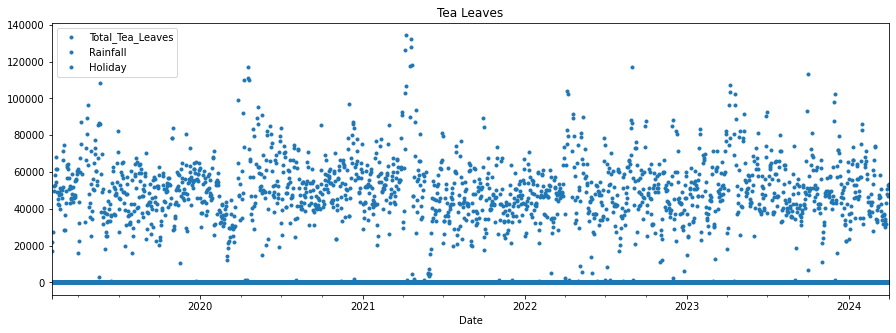

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Tea Leaves')
plt.show()

# Train / Test Split

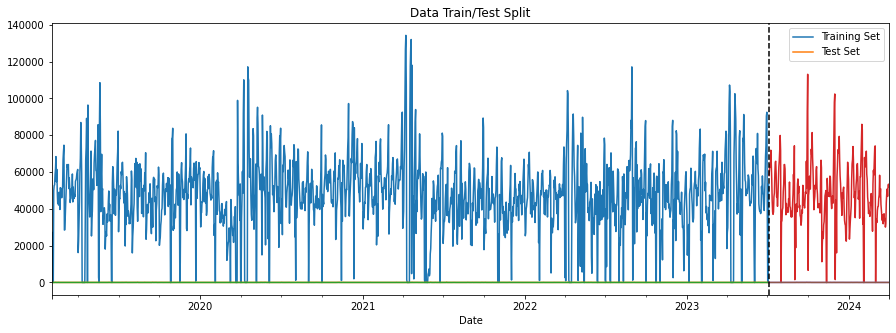

In [6]:
train = df.loc[df.index < '07-05-2023']
test = df.loc[df.index >= '07-05-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('07-05-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
train

,Total_Tea_Leaves,Rainfall,Holiday
Date,,,
2019-02-01,17279.0,0.0,0.0
2019-02-02,21965.0,0.0,0.0
2019-02-03,27204.0,0.0,0.0
2019-02-04,0.0,0.0,1.0
2019-02-05,49832.0,10.1,0.0
...,...,...,...
2023-06-30,92474.0,0.0,0.0
2023-07-01,37725.0,14.2,0.0
2023-07-02,0.0,20.2,0.0


# Feature Creation

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

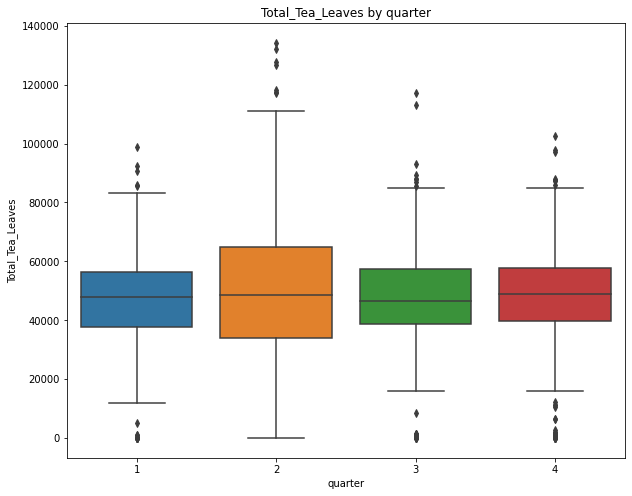

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='Total_Tea_Leaves')
ax.set_title('Total_Tea_Leaves by quarter')
plt.show()

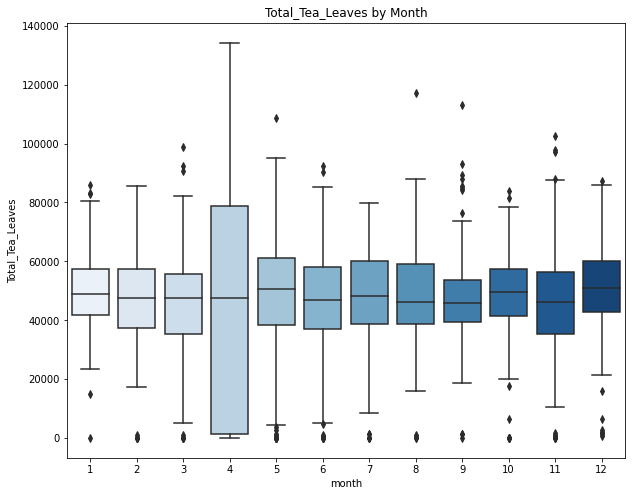

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Total_Tea_Leaves', palette='Blues')
ax.set_title('Total_Tea_Leaves by Month')
plt.show()

# Create our Models

In [11]:
test

,Total_Tea_Leaves,Rainfall,Holiday
Date,,,
2023-07-05,58038.0,11.3,0.0
2023-07-06,61885.0,0.0,0.0
2023-07-07,64075.0,0.0,0.0
2023-07-08,62642.0,0.0,0.0
2023-07-09,71854.0,0.0,0.0
...,...,...,...
2024-03-27,50801.0,12.7,0.0
2024-03-28,46742.0,6.4,0.0
2024-03-29,52710.0,0.0,1.0


In [12]:
train = create_features(train)
test = create_features(test)
train['weekofyear'] = train['weekofyear'].astype('int')
test['weekofyear'] = test['weekofyear'].astype('int')

FEATURES = ['dayofyear','Holiday','dayofmonth','month','Rainfall']
TARGET = 'Total_Tea_Leaves'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=10,
    n_estimators=1200,
    early_stopping_round=50,
    objective='regression',
    max_depth=4,
    learning_rate=0.01,
#     early_stopping_rounds=100,
    eval_metric  = 'rmse',
)

lgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
    early_stopping_rounds=50
)

# from sklearn.metrics import mean_squared_error

y_pred =lgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: eval_metric
[100]	training's l2: 3.03199e+08	valid_1's l2: 1.69282e+08
[200]	training's l2: 2.61875e+08	valid_1's l2: 1.44359e+08
[300]	training's l2: 2.28545e+08	valid_1's l2: 1.36123e+08
[400]	training's l2: 2.05523e+08	valid_1's l2: 1.30611e+08
[500]	training's l2: 1.91694e+08	valid_1's l2: 1.25963e+08
[600]	training's l2: 1.83315e+08	valid_1's l2: 1.21275e+08
[700]	training's l2: 1.77033e+08	valid_1's l2: 1.19536e+08
[800]	training's l2: 1.7219e+08	valid_1's l2: 1.18951e+08
RMSE: 10899.059713575856


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    random_state=42
)

gb_reg.fit(X_train, y_train)
y_pred =gb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 10794.8687778505


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest Regressor model
rf_reg_feat = RandomForestRegressor(n_estimators=800, max_depth=10, random_state=42)

# Fit the model
rf_reg_feat.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_rf_feat = rf_reg_feat.predict(X_test)
rmse_rf_feat = np.sqrt(mean_squared_error(y_test, y_pred_rf_feat))
print(f'RMSE for Random Forest Regressor with Feature Importance: {rmse_rf_feat}')

# Feature importance
importances = rf_reg_feat.feature_importances_
print("Feature importances:", importances)


RMSE for Random Forest Regressor with Feature Importance: 11017.741364436606
Feature importances: [0.27729565 0.08133004 0.4296156  0.09366221 0.11809651]


In [16]:
from catboost import CatBoostRegressor

# Create the CatBoost Regressor model
catboost_reg = CatBoostRegressor(
    iterations=8500,
    learning_rate=0.05,
    depth=4,
    loss_function='RMSE',
    verbose=100
)

# Fit the model
catboost_reg.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predict and calculate RMSE
y_pred_catboost = catboost_reg.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print(f'RMSE for CatBoost Regressor: {rmse_catboost}')


0:	learn: 20378.4563670	test: 16678.4406641	best: 16678.4406641 (0)	total: 54.4ms	remaining: 7m 42s
100:	learn: 15282.7986713	test: 11633.7576374	best: 11633.7576374 (100)	total: 111ms	remaining: 9.24s
200:	learn: 13834.6095162	test: 11099.4747346	best: 11099.4747346 (200)	total: 171ms	remaining: 7.04s
300:	learn: 13169.7952754	test: 10888.4643471	best: 10886.6847768 (298)	total: 240ms	remaining: 6.53s
400:	learn: 12701.3377615	test: 10707.9642985	best: 10707.9642985 (400)	total: 297ms	remaining: 6s
500:	learn: 12351.6041683	test: 10632.8187972	best: 10632.8187972 (500)	total: 361ms	remaining: 5.76s
600:	learn: 12089.1785700	test: 10557.0514475	best: 10557.0362588 (595)	total: 428ms	remaining: 5.63s
700:	learn: 11850.4344663	test: 10509.0976970	best: 10509.0976970 (700)	total: 495ms	remaining: 5.51s
800:	learn: 11629.0460911	test: 10517.4381260	best: 10502.9845846 (706)	total: 563ms	remaining: 5.42s
900:	learn: 11446.8536063	test: 10510.3868612	best: 10495.0376395 (837)	total: 630ms	re

In [17]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# model = keras.Sequential([
#     layers.Dense(64, activation='relu'),
#     layers.BatchNormalization(),  # Add batch normalization layer
    
#     # Hidden layer 1
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),  # Add batch normalization layer
#     layers.Dropout(0.3),  # Add dropout for regularization
    
#     # Hidden layer 2
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),  # Batch normalization
    
#     # Hidden layer 3
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),

#     # Hidden layer 4
#     layers.Dense(512, activation='relu'),
#     layers.BatchNormalization(),
    
#     # Output layer
#     layers.Dense(1)
# ])

# # Compile the model
# model.compile(optimizer=Adam(0.01), loss='mae')
# # Train the model
# model.fit(X_train, y_train, epochs=100, validation_split=0.1)


In [18]:
reg = xgb.XGBRegressor(base_score=0.6, booster='gbtree',    
                       n_estimators=2500,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


y_pred =reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


[0]	validation_0-rmse:51174.52443	validation_1-rmse:50473.56464
[100]	validation_0-rmse:24356.45542	validation_1-rmse:21445.23928
[200]	validation_0-rmse:16776.13170	validation_1-rmse:13257.77538
[300]	validation_0-rmse:14612.71203	validation_1-rmse:11590.29331
[400]	validation_0-rmse:13499.51069	validation_1-rmse:11129.84357
[500]	validation_0-rmse:12924.64868	validation_1-rmse:10982.03464
[600]	validation_0-rmse:12548.58131	validation_1-rmse:10872.84812
[700]	validation_0-rmse:12289.44360	validation_1-rmse:10798.07651
[800]	validation_0-rmse:12066.08262	validation_1-rmse:10695.22088
[900]	validation_0-rmse:11898.41026	validation_1-rmse:10643.60561
[1000]	validation_0-rmse:11739.26029	validation_1-rmse:10631.84246
[1100]	validation_0-rmse:11527.26778	validation_1-rmse:10622.73177
[1143]	validation_0-rmse:11455.84884	validation_1-rmse:10625.51204
RMSE: 10621.3896484375


In [19]:



# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV, KFold

# # Define the model
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree')

# # Define the parameters grid
# param_grid = {
#     'base_score': [ 0.6, 0.7],
#     'n_estimators': [500,600],
#     'max_depth': [3, 4,5],
#     'learning_rate': [0.05]
# }

# # Setup cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Setup the GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kf, verbose=500, scoring='neg_root_mean_squared_error')

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=500)  # Make sure X and y are your data features and target variable

# # Best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

# # You can also access the best estimator directly
# best_model = grid_search.best_estimator_


# Feature Importance

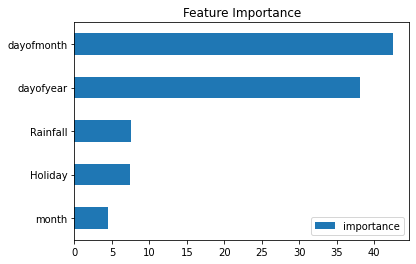

In [20]:
fi = pd.DataFrame(data=catboost_reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [21]:
test['prediction'] = catboost_reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [22]:
test

,Total_Tea_Leaves,Rainfall,Holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Date,,,,,,,,,,,
2023-07-05,58038.0,11.3,0.0,2,3,7,2023,186,5,27,46624.779277
2023-07-06,61885.0,0.0,0.0,3,3,7,2023,187,6,27,49354.458224
2023-07-07,64075.0,0.0,0.0,4,3,7,2023,188,7,27,56495.875205
2023-07-08,62642.0,0.0,0.0,5,3,7,2023,189,8,27,62823.725334
2023-07-09,71854.0,0.0,0.0,6,3,7,2023,190,9,27,64293.480731
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,50801.0,12.7,0.0,2,1,3,2024,87,27,13,54330.143513
2024-03-28,46742.0,6.4,0.0,3,1,3,2024,88,28,13,58753.253031
2024-03-29,52710.0,0.0,1.0,4,1,3,2024,89,29,13,68707.504118


In [23]:

test['prediction'] = test['prediction'].apply(clean)
# test['Total_Tea_Leaves'] = scaler.inverse_transform(test[["Total_Tea_Leaves"]])
# test['prediction'] = scaler.inverse_transform(test[["prediction"]])



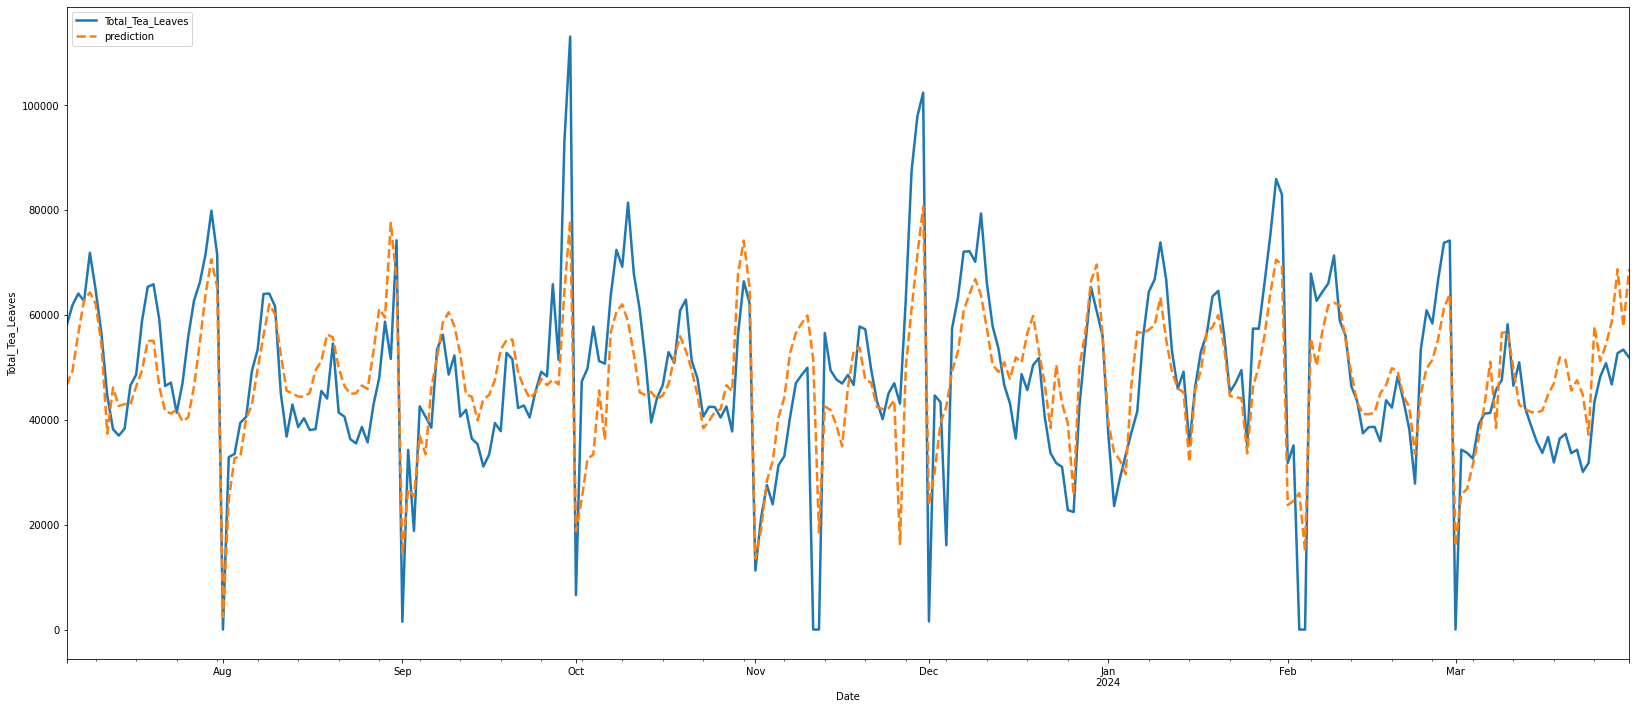

In [24]:
ax1 = test[["Total_Tea_Leaves"]].plot(label = 'Observed',linewidth=2.5)
test[["prediction"]].plot(ax = ax1, label = 'Forecast', figsize = (28, 12), linestyle = 'dashed',linewidth=2.5)


#Finding the confidence intervals of the forecasts.
ax1.set_xlabel('Date')
ax1.set_ylabel('Total_Tea_Leaves')
plt.legend(loc = 'upper left')
plt.show()


# Score (RMSE)

In [25]:
score = np.sqrt(mean_squared_error(test['Total_Tea_Leaves'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 10477.19


# Calculate Error
- These are the outliers from predictions

In [26]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-11-11    51527.643153
2023-09-30    35078.547947
2023-09-29    28437.219087
2023-11-26    26774.011903
2023-11-29    26441.382036
2023-12-04    26428.224733
2023-11-28    26347.470330
2024-02-03    26023.166753
2023-08-30    25977.743450
2023-10-04    24414.359766
Name: error, dtype: float64